![title](Beach.jpg)

# Business Understanding
Ask relevant questions and define objectives for the problem that needs to be tackled
## Glossary
* **id** - unique identified for a house
* **dateDate** - house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  of Bedrooms/House
* **bathroomsNumber** -  of bathrooms/bedrooms
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

## Data Sets
* **data_raw** - Originally imported dataset
* **data** - Main working dataset containing cleaned and refined data

## Open Topics
- Change color palette to fit Google Slides

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import seaborn as sns
import math

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
sns.set()
%matplotlib inline

# Data Mining
Gather and scrape the data necessary for the project

In [2]:
data_raw = pd.read_csv("King_County_House_prices_dataset.csv")
data = data_raw

In [3]:
data.shape

(21597, 21)

In [4]:
# data.info()

In [5]:
# data.corr().head()

In [6]:
# data.describe()

In [7]:
# data.columns

In [8]:
# data.head()

# Data Cleaning
Fix the inconsistencies within the data and handle the missing values

- date
- sqft_basement
- waterfront
- view
- outliers:
  - bedrooms
  - sqft_living
  - sqft_lot

In [9]:
# date: split into date_month and date_year, and make date a continuum from min to max - OPTIMIZE
data["date_month"] = [int(el.split("/")[0]) for el in data.date.values.tolist()]
data["date_year"] = [int(el.split("/")[2]) for el in data.date.values.tolist()]
data.date_old = data.date
data.date = data.date_month + (data.date_year-2014)*12

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.


In [10]:
# sqft_basement: set to sqft_living - sqft_above
data.sqft_basement = data.sqft_living - data.sqft_above

In [11]:
# waterfront: Assume NaN=0
data.waterfront.fillna(0.0, inplace=True)

In [12]:
# view: Assume NaN=0
data.view.fillna(0.0, inplace=True)

In [13]:
# outliers: bedrooms (33 beds) - OPTIMIZE (how to remove outliers in a more systematic manner?)
data.drop(data.loc[data.bedrooms==data.bedrooms.max()].index.tolist(), axis=0, inplace=True)

In [14]:
# outliers: sqft_living (2)
data.drop(data.loc[data.sqft_living==data.sqft_living.max()].index.tolist(), axis=0, inplace=True)
#data.drop(data.loc[data.sqft_living==data.sqft_living.max()].index.tolist(), axis=0, inplace=True)

In [15]:
# outliers: sqft_lot
data.drop(data.loc[data.sqft_lot==data.sqft_lot.max()].index.tolist(), axis=0, inplace=True)

# Data Exploration
Form hypotheses about your defined problem by visually analyzing the data

In [16]:
# separate continuous vs. categorical variables
data_cat = ['condition','grade','zipcode']
data_cont = [el for el in data.columns if el not in data_cat]

In [17]:
# correlation heatmap
mask = np.triu(data_cont.corr())
ax = sns.heatmap(round(data_cont.corr()*100,0)
                 ,annot=True
                 ,mask=mask
                 ,cmap='coolwarm')
ax.set_ylim((0,11))

AttributeError: 'list' object has no attribute 'corr'

In [27]:
# Plot all variables as pairplot
#sns.pairplot(data);

In [ ]:
# Plot selection of variables as pairplot
#sns.pairplot(data, kind="reg", vars=["price", "bedrooms", "bathrooms", "sqft_lot"], 
#             plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}});

In [24]:
# Plot continuous variables
#plt.hist(data.price, bins = 25);
#plt.hist(np.log(data.price), bins = 25);
#plt.tight_layout()

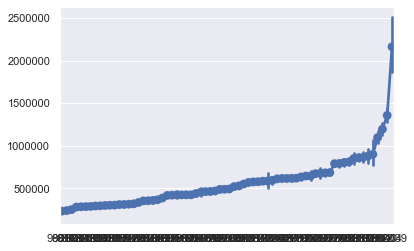

In [28]:
# Plot categorical variables
#sns.stripplot(x=data.condition.values, y = data.price.values, 
#              jitter=0.1, alpha=0.5);

#sns.stripplot(x=data.grade.values, y = data.price.values,
#              jitter=0.1, alpha=0.5);

#sns.stripplot(x=data.zipcode.values, y = data.price.values,
#              jitter=0.1, alpha=0.5);

sns.pointplot(x = data.zipcode.values, y = data.price.values,
              order = data.groupby("zipcode")["price"].mean().sort_values().index);

#plt.tight_layout()

# Feature Engineering
Select important features and construct more meaningful ones using the raw data that you have

- renovated
- price_log: column with log of price
- yr_since_built: column with years between yr_built and sold
- yr_last_renovated: column with max from yr_built und yr_renovated
- yr_since_last_renovated: column with years between yr_built or yr_renovated and sold
- categorical --> dummies
  - condition
  - grade
  - zipcode
- drop:
  - id
  - yr_renovated

In [ ]:
# renovated: Add 1/0 variable for whether house has been renovated, assuming 0 for NaN-Values
data["renovated"] = data["yr_renovated"] > 0
data.renovated.replace([True, False], [1, 0], inplace=True)

In [ ]:
# price_log: column with log of price
# data.head()
data["price_log"] = [math.log(el) for el in data["price"]]
# data.price_log.hist();

In [ ]:
# yr_since_built
data["yr_since_built"] = data.date_year - data.yr_built

In [ ]:
# yr_last_renovated
#data["yr_last_renovated"] = [max(data.yr_built[i],data.yr_renovated[i]) for i in data.yr_built]
data["yr_last_renovated"] = data[["yr_built","yr_renovated"]].max(axis=1)

In [ ]:
# yr_since_last_renovated
data["yr_since_last_renovated"] = data.date_year - data.yr_last_renovated

In [ ]:
# categorical --> dummies - OPTIMIZE
cat = data.filter(["condition", 
                   "grade", 
                   "zipcode"], axis=1).astype("category")
data_dum = pd.DataFrame()
data_dum_i = pd.DataFrame()
for i in cat:
    data_dum_i = pd.get_dummies(cat[i], prefix=i, drop_first=True)
    data_dum = pd.concat([data_dum, data_dum_i], axis=1)
data_without_dum = data
data = pd.concat([data, data_dum], axis=1)
# data_dum = pd.get_dummies(data, columns=["condition", "grade", "zipcode"], prefix=["condition", "grade","zipcode"])
# data_wo_dum = data
# data_new = pd.concat([data, data_dum], axis=1)

In [ ]:
# drop: id, yr_renovated
data = data.drop(["id", "date", "yr_renovated", "condition", "grade", "zipcode", "sqft_living"], axis=1)

# Predictive Modeling
Train machine learning models, evaluate their performance and use them to make predictions

In [ ]:
# Split data into test and train

In [ ]:
X = data.drop(["price", "price_log"], axis=1)
X = sm.add_constant(X)
y = data.price
data_results = sm.OLS(y,X).fit()
data_results.summary()

In [ ]:
data.columns
#data
#data.yr_since_built

In [ ]:
X2 = data.drop(["price", "price_log", "renovated", "yr_since_last_renovated", 
               "yr_last_renovated", "yr_built"], axis=1)
X2 = sm.add_constant(X2)
y2 = data.price
data_results = sm.OLS(y2,X2).fit()
data_results.summary()

In [ ]:
X3 = data[['bedrooms', 'bathrooms', 'sqft_lot', 'floors',
       'waterfront', 'view', 'sqft_above',
       'sqft_basement', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'renovated', "grade_12", 
       "grade_13", "yr_since_last_renovated"]]
X3 = sm.add_constant(X3)
y3 = data.price
data_results = sm.OLS(y3,X3).fit()
data_results.summary()

In [ ]:
y4 = data['price']
X4 = data[['bathrooms','bedrooms','sqft_above','floors']]
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.3, random_state=101)

lm = LinearRegression()
lm.fit(X4_train,y4_train)
print('Coefficients: \n', lm.coef_)

predictions = lm.predict(X4_test)
plt.scatter(y4_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

# calculate these metrics by hand!
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

In [ ]:
sns.distplot((y_test-predictions),bins=50)

# Data Visualization
Communicate the findings with key stakeholders using plots and interactive visualizations